# Sentiment Analysis


Our decisions have a great relationship with the opinions of others. As an organization, this can be more valuable to find out how customers think about their products and services. The challenging part is, at some point, there is going to be lots of data that a human can gain useful information. So we need machines' computation power to deal with those and gives us compact insight to draw on for our decision making. Computers are already better than humans when it comes to numbers. They are faster and more accurate. But when it comes to something natural like human languages, that aren't designed for computers, it is more challenging. Dealing with Natural language wasn't possible until recently. Now, we have lots of data that we can draw upon them. It turns out by finding some statistical relationships among words and sentences instead of finding some strict logical rules (that lots of smart people have worked on in the past), we can do a better job.
In this notebook, we will use data samples of review texts about some products on Amazon. By finding statistical relationships between words, we are going to create a reasonable model that can predict if costumers have a negative or positive opinion on the given product.

### Getting The Data 

Our data is stored in google drive and we use the drive to store other Data as well. Here we mount the google drive with authorization code.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We import all the libraries we going to use in this section. The explantion of the use is written as comment.

In [2]:
%matplotlib inline
import pandas as pd # Using panada data frame for stroing and manipulating data
import nltk  # Used for NLP processing like Naive Bayes Classification 

import numpy as np # Used for leveraging vectorization for more efficiency along side of DataFrame
from wordcloud import WordCloud, STOPWORDS # For creating cloud of words

from sklearn.feature_extraction.text import CountVectorizer # For creating bag-of-words
from sklearn.model_selection import train_test_split # Splitting the data to train set and test set

# from sklearn.feature_extraction import text # 
import matplotlib.pyplot as plt # For plotting graphs
from nltk.tokenize import word_tokenize  # Tokenize texts to words

import re # Cleaning some patterns that doesn't give us value
import string # Used for geting the set of punctuation 

import scipy.stats as st # Using one-way-Anova for feature extraction
import pickle # For saving processed data at each stage 

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # Stemmizing the words to their roots

from textblob import TextBlob # Used it's general plarity detection to compare it's performance to our model
from sklearn import preprocessing # Used for scaling data to represent fair comparison for our prediction and TextBlob prediction
import six

nltk.download('punkt') # downloading punctuation data's used by nltk lib
nltk.download('stopwords')
STOP_WORDS = stopwords.words('english')
# Change working dir to google drive
import os
os.chdir('/content/drive/My Drive/data/')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Read reviews 
reviews = pd.read_json('reviews.txt', lines=True)
# Read labels 
labels = pd.read_csv('labels.txt', names=['rate'])

In [4]:
# Combine reviews' reviewText with labels
data = pd.concat((reviews[['reviewText']], labels), axis=1)
# Removing neutral sentiments
data = data[data.rate != 3]
# Display data
data

,reviewText,rate
0,Corey Barker does a great job of explaining Bl...,5
1,It never worked. My daughter worked to earn th...,1
2,Do not waste your money on this thing it is te...,1
3,"This remote, for whatever reason, was chosen b...",2
4,We had an old Time Warner Cable remote that wa...,5
...,...,...
15996,Well I bought this unit on a saturday afternoo...,4
15997,I have read that this is a good product if one...,1
15998,"I bought this card at the going rate, because ...",5
15999,I purchased this card as one of the original g...,2


In [5]:
# Remove Some data from positive oponion to have more balance data
# to_remove = np.random.choice(data[lambda x: x['rate'] > 3].index,size=7068,replace=False)
# data =data.drop(to_remove)

In [6]:
# Let's print size of positive and nagative data
p_data_size = data[lambda x: x['rate'] > 3].index.size
n_data_size = data[lambda x: x['rate'] < 3].index.size
print(f'size of positive data: {p_data_size}\nsize of negative data: {n_data_size}')

size of positive data: 11653
size of negative data: 3101


### Cleaning The Data 

Cleaning data is a crucial step in any data science pipeline. We try to remove the things that have no reasonable meaning or effect in our model to deal with less meaningful data. This cleaning can take forever, so we start with minimal reasonable ones, and through more iterations, we add other rounds to it.

In the first cleaning round, words with digits and punctuation are removed from the review texts.

In [7]:
# Apply first round of text cleaning techniques
def clean_text_round1(text):
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

data['reviewText'] = data['reviewText'].apply(clean_text_round1)

In [8]:
stemmer = PorterStemmer()

def clean_text_round2(text):
  word_tokens = word_tokenize(text)
  stem_words = [stemmer.stem(word) for word in word_tokens if word not in STOP_WORDS]
  return ' '.join(stem_words)

data['reviewText'] = data['reviewText'].apply(clean_text_round2)

In [9]:
# Splitting the dataset into train and test set
train, test = train_test_split(data, test_size=0.1)

# Display train data
train.sample(10)

,reviewText,rate
12753,thi sterio great sound system deliv great musi...,5
1321,great bought gift mom christma love came packa...,5
11626,I bought nino decemb incred price two monthsla...,4
12319,I want extens cabl situat laptop could comfort...,5
12077,it cat cabl blue short work Do realli need rea...,4
10324,I read palm expens but good support team write...,5
2010,I hate nook BN I spend month research compar n...,1
1153,I love I glad I bought A good reader I like on...,5
9949,thi batteri pack new fulli charg take around p...,4
3268,ship fast soo pretti feel durabl bought friend...,5


### Document-Term Matrix (Bag-of-words)


Using scikit-learn's CountVectorizer, representing every documents as a vector of words that each unique words represent by a column header. In addition, with CountVectorizer, we can remove stop words.

In [10]:
# Removing stop words while creating DTM
cv = CountVectorizer(stop_words=STOP_WORDS)

data_cv = cv.fit_transform(train['reviewText'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
# synchronizing the indexes
data_dtm.index = train.index

data_dtm[data_dtm.columns.to_series().sample(10)]


,tarnish,headachesmi,multimet,mt,udii,handspr,canecel,amasi,latermark,phonepda
1957,0,0,0,0,0,0,0,0,0,0
6172,0,0,0,0,0,0,0,0,0,0
10095,0,0,0,0,0,0,0,0,0,0
12196,0,0,0,0,0,0,0,0,0,0
7297,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
30,0,0,0,0,0,0,0,0,0,0
3467,0,0,0,0,0,0,0,0,0,0
4932,0,0,0,0,0,0,0,0,0,0
7786,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis 

In this phase we try to gain some insight about our data and make sure our cleaning were ok.
So we start by looking at most frequent words in our review texts. You can comment out this part and use the previously pickled files.

In [11]:
# Top 20 most frequent words in in comments
mfw  = pd.DataFrame(np.count_nonzero(data_dtm,axis=0), data_dtm.columns).nlargest(20,0)
mfw.to_pickle('mfw.pkl')

# Frequency of most frequent words in high rated comments
high_rate_indexes =train.loc[lambda df: df['rate'] >3].index
high_rated_w_freq = pd.DataFrame(np.count_nonzero(data_dtm.loc[high_rate_indexes],axis=0)/high_rate_indexes.size, data_dtm.columns)
hr_mfw = high_rated_w_freq.loc[mfw.index]

hr_mfw.to_pickle('hr_mfw.pkl')

# Frequency of most frequent words in low rated comments
low_rate_indexes =train.loc[lambda df: df['rate'] <3].index
low_rated_w_freq = pd.DataFrame(np.count_nonzero(data_dtm.loc[low_rate_indexes],axis=0)/low_rate_indexes.size, data_dtm.columns)
lr_mfw = low_rated_w_freq.loc[mfw.index]

lr_mfw.to_pickle('lr_mfw.pkl')

In [12]:
mfw = pd.read_pickle( 'mfw.pkl')
hr_mfw = pd.read_pickle('hr_mfw.pkl')
lr_mfw = pd.read_pickle('lr_mfw.pkl')


Now let's see frequency of those frequent words in out high-rated and low-rated reviews to compare them.

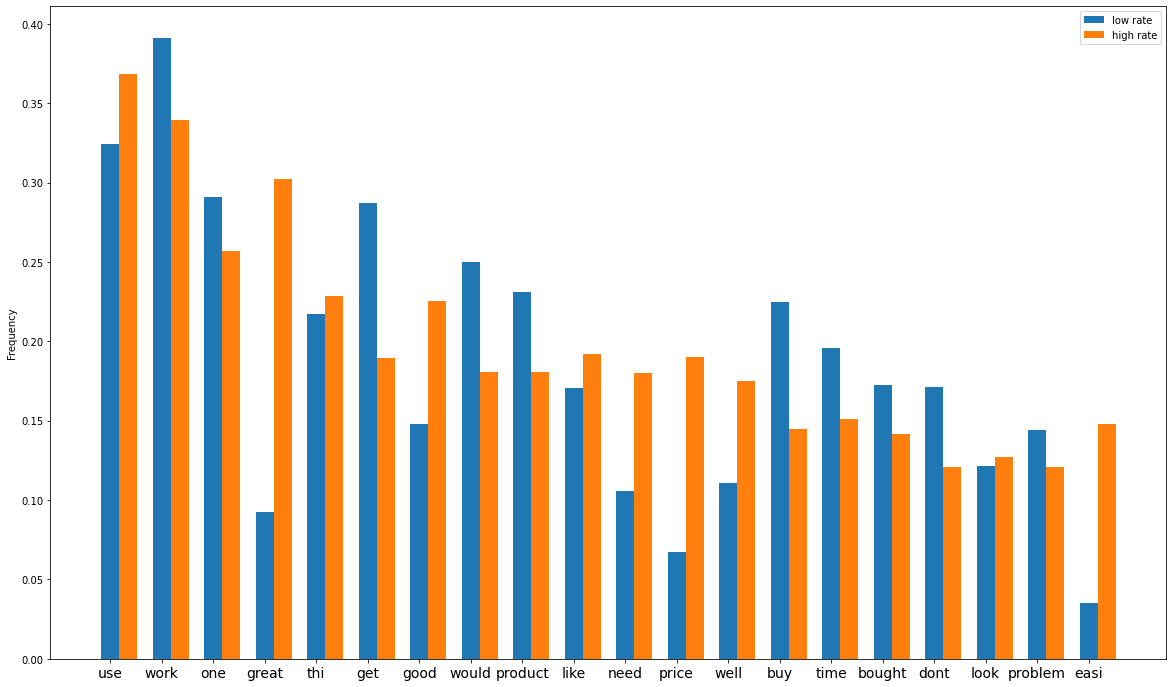

In [13]:
x_pos = np.arange(mfw.index.size)

width = .35
fig, ax = plt.subplots()

ax.bar(x_pos,lr_mfw[0].values, width, align='center', label='low rate')
ax.bar(x_pos + width, hr_mfw[0].values, width, align='center',label='high rate')

ax.set_ylabel('Frequency')
plt.xticks(x_pos, mfw.index, fontsize=14)
ax.legend()

fig.set_size_inches(20, 12, forward=True)
fig.savefig('mfw.pdf', bbox_inches='tight')
fig.show()

Positive words


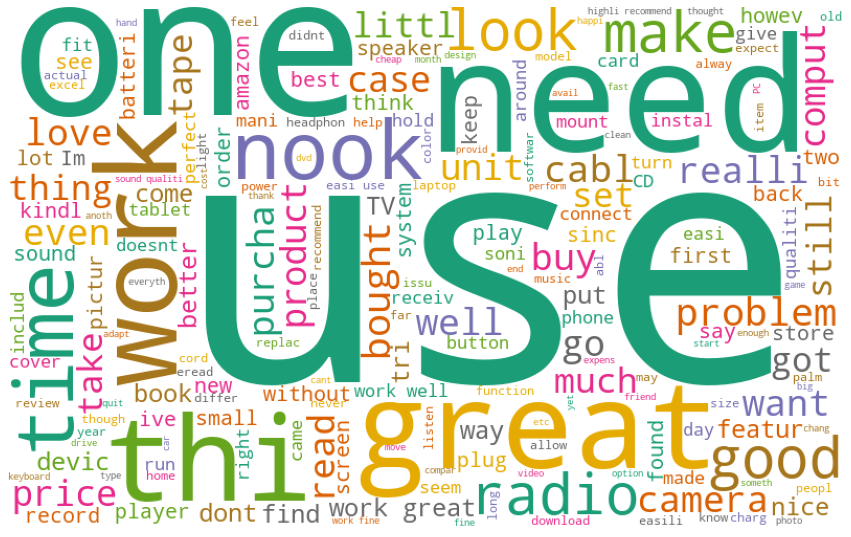

Negative words


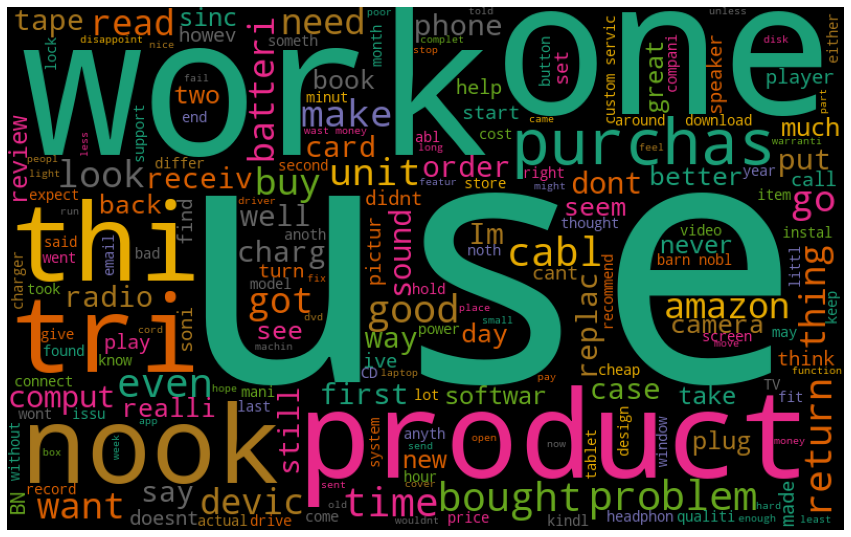

In [37]:
# Splitting positive and negative review
train_pos = train[train.rate>3]
train_pos = train_pos.reviewText
train_neg = train[train.rate<3]
train_neg = train_neg.reviewText

def wordcloud_draw(data, color = 'black',extra_stop=set()):
  words = ' '.join(data)
  wc = WordCloud(stopwords=STOPWORDS.union(extra_stop), background_color=color,
                 colormap="Dark2", width=800, height=500,
                  random_state=42).generate(words)
  plt.figure(1,figsize=(15, 10))
  plt.imshow(wc)
  plt.axis('off')
  plt.savefig(color+'wordcloud-ex.pdf', bbox_inches='tight')
  plt.show()

print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)
               

Using this word cloud, we also see frequent words in a more compact way. As you can see, some words like **nook**, **thi (this)** and **thing** are almost equal in size in both negative and positive reviews. On the other hand, words like **great**, **good** and **need** are bigger in postivie reviews and words like **tri (try)**, **product** and **problem** are bigger in negative reviews.

## Feature extraction

In this section, we try to remove features (words) that have no values or discriminating meanings. What we can do is to remove the words that have the same mean in both high-rated and low-rated reviews. Using [ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance#:~:text=Analysis%20of%20variance%20(ANOVA)%20is,by%20the%20statistician%20Ronald%20Fisher.) (statistical method), we can find if two groups of populations have the same mean or not. With the use of **stats.f_oneway** we can find p-value( Level of Significance), and if this value is less than 0.05, it means that with a good margin, the two populations have different means.

In [15]:
# High polarity words
hp_words = set()
# Low polarity words
lp_words = set()

# This part takes long time the result has saved in the Pickle files
pos_population = data_dtm.loc[high_rate_indexes]
neg_population = data_dtm.loc[low_rate_indexes]
for word in data_dtm.columns:
  neg_pop = neg_population[word].values
  pos_pop = pos_population[word].values 
  if st.f_oneway(pos_pop, neg_pop).pvalue > .05:
    lp_words.add(word)
  else:
     hp_words.add(word)

pickle.dump(hp_words, open('hp_words.pkl','wb'))
pickle.dump(lp_words, open('lp_words.pkl','wb'))

with open('hp_words.pkl', 'rb') as pickle_file:
  hp_words = pickle.load(pickle_file)

with open('lp_words.pkl', 'rb') as pickle_file:
  lp_words = pickle.load(pickle_file)



Plotting word cloud of words with the diffrent frequency mean in high-rated and low-rated reviews.

Positive words


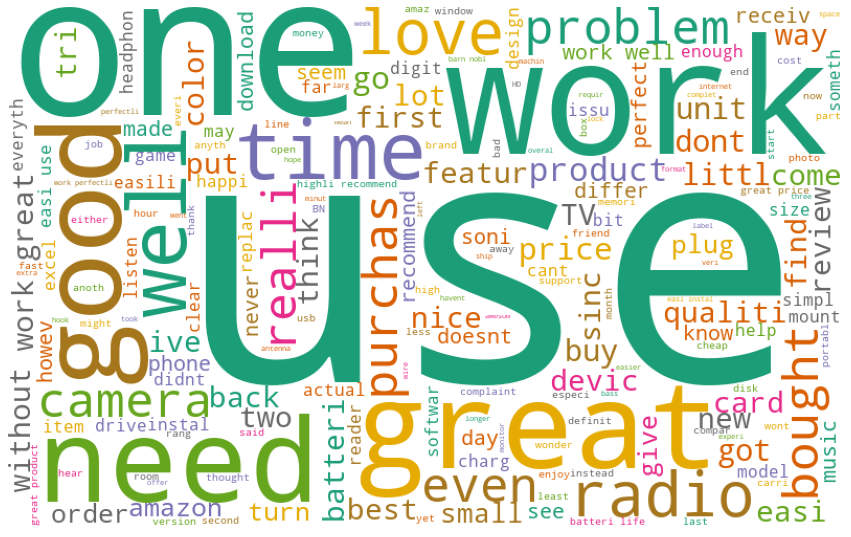

Negative words


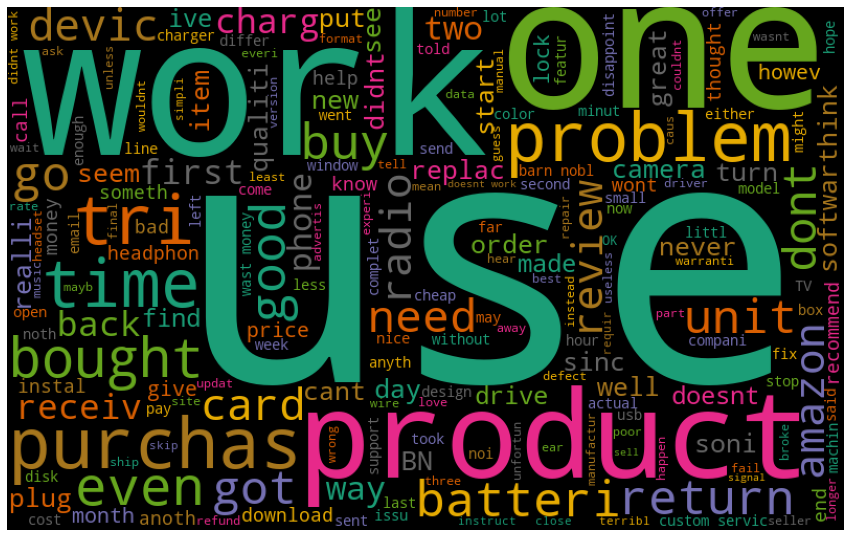

In [38]:

print("Positive words")
wordcloud_draw(train_pos,'white',lp_words)
print("Negative words")
wordcloud_draw(train_neg,'black',lp_words)

Number of remaining features.


In [17]:
len(hp_words)

1440

Functions for tokenizing and extracting features from the review texts. *extract_features* is used in *nltk.classify.apply_features*.

In [18]:
# tokenizing reviewText with stemming and removing stop words
def get_words_in_review(review_text):
  words = word_tokenize(review_text)
  words = [stemmer.stem(word) for word in words if word not in STOPWORDS]
  return words
# Creat feature dictionary for each review
# base on discriminating words we found before
def extract_features(review_words):
  features = {}
  for word in hp_words:
    features['contains(%s)' % word] = (word in review_words)
  
  return features

Create a proper format for using classifier in the next section.

In [19]:
# Tokenize review texts 
train_set_words = train['reviewText'].apply(lambda x: get_words_in_review(x))

# Binary labeling for rates
# Using vectorization to boost efficiency
vf = np.vectorize(lambda x: 'pos' if x > 3 else 'neg')
train_set_label = train['rate'].values
train_set_label = np.array(list(map(vf , train_set_label)))

# Preparing data for using in feactures extraction using nltk for more efficiency
train_set = list(zip(train_set_words, train_set_label))


## Traning

In this section, after preparation of training set, we use [**NaiveBayesClassifier**](https://www.nltk.org/_modules/nltk/classify/naivebayes.html) to train our model.

In [20]:
# Create training set by extracting 
training_set = nltk.classify.apply_features(extract_features,train_set,labeled=True)

In [21]:
# Train the model
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [22]:
# Save the trained classifier to save time for later use
with open('bayes_classifier.pkl', 'wb') as f:
  pickle.dump(classifier, f)
  
# Load the classifier from the pickle file
with open('bayes_classifier.pkl', 'rb') as f:
  classifier = pickle.load(f)

## Testing

Now, it's the time to test our model against the test set. Counting the number of true postive and true negative.

In [23]:
# Variable for counting number of True Postive
neg_cnt = 0
# Variable for counting number of True Nagative
pos_cnt = 0

# Spliting negetive and postive reviews in test set
test_neg = test[test.rate<3]
test_pos = test[test.rate>3]

# Tokenize and preprocess review texts
test_neg_words = test_neg['reviewText'].apply(lambda x: get_words_in_review(x))
test_pos_words = test_pos['reviewText'].apply(lambda x: get_words_in_review(x))

# Counting number of True Nagative and True Positive
for obj in test_neg_words:
  res = classifier.classify(extract_features(obj))
  if res == 'neg':
    neg_cnt += 1
for obj in test_pos_words:
  res = classifier.classify(extract_features(obj))
  if res == 'pos':
    pos_cnt += 1

Calculating different test scorings.

In [24]:
TP = pos_cnt
FN = test_pos_words.size - pos_cnt
FP = test_neg_words.size - neg_cnt
TN = neg_cnt
accuracy = (TP + TN)/(TP + FP + TN + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
print(f'Recall:{Recall}, Precision: {Precision}, Accuracy: {accuracy}')

Recall:0.9251290877796902, Precision: 0.9018456375838926, Accuracy: 0.8617886178861789


Let's plot the confusion-matrix to see the different asspect of our testing scores and the accuracy.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


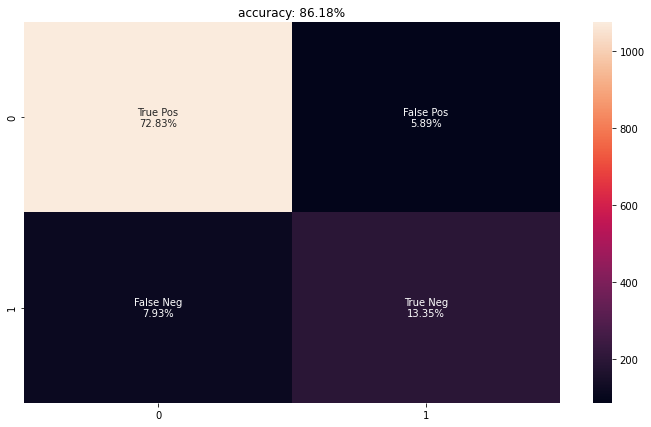

In [25]:
import seaborn as sns

cf_matrix = np.array([TP, FN, FP, TN])
group_names = ['True Pos','False Pos','False Neg','True Neg']
labels =  [f'{g}\n{p:.2%}' for g,p in zip(group_names, cf_matrix/np.sum(cf_matrix))]
labels = np.asarray(labels).reshape(2, 2)
cf_matrix = cf_matrix.reshape(2,2)
f, ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap(cf_matrix, annot=labels,fmt='')

ax.set_title(f'accuracy: {accuracy:.2%}')
# plt.savefig('conf_matrix.pdf', bboz_inches='tight')
plt.show()


Now let's use the TextBlob sentiment tool to calculate the polarity of the review texts and compare it with our Naive Bayes model (find the positive probability of each review) and scale them between 0 to 1 to have a fair comparison.

In [35]:
# To surpress the wrong warning of chained assignment
pd.options.mode.chained_assignment = None  # default='warn'
# Function that find polarity of a text
pol = lambda x: TextBlob(x).sentiment.polarity

# Function that find probability how much a text is positive
# base on the trained naive bayes classifier
prob = lambda x : classifier.prob_classify(extract_features(x)).prob('pos')

# Apply polarity function and scale the value between 0 to 1
polarity = test.loc[:,'reviewText'].apply(pol).values
min_max_scaler = preprocessing.MinMaxScaler()
test['polarity'] =min_max_scaler.fit_transform(polarity.reshape(-1,1))[:,0]

# Apply prob function and scale the value between 0 to 1
test['reviewWords'] = test['reviewText'].apply(lambda x: get_words_in_review(x))
prob = test['reviewWords'].apply(prob).values
test['prob'] = min_max_scaler.fit_transform(prob.reshape(-1,1))[:,0]
test

,reviewText,rate,polarity,reviewWords,prob
15269,decent handheld work okay much rang get pay,4,0.581699,"[decent, handheld, work, okay, much, rang, pay]",0.989158
11803,the talkabout seem clunki design specif placem...,5,0.588235,"[talkabout, seem, clunki, design, specif, plac...",0.954753
15109,I purchas item two reason road trip commun off...,5,0.476747,"[I, purcha, item, two, reason, road, trip, com...",0.013637
8741,for low price great It true belkin qualitylow ...,5,0.604412,"[low, price, great, It, true, belkin, qualityl...",0.999958
5315,I need buy replac comput cabl garman two month...,5,0.611111,"[I, need, buy, replac, comput, cabl, garman, t...",0.580953
...,...,...,...,...,...
10610,Im moder comfort pc innard Im hardwar guru the...,5,0.411765,"[Im, moder, comfort, pc, innard, Im, hardwar, ...",0.997065
10809,apc product offer excel valu devic market enou...,5,0.411765,"[apc, product, offer, excel, valu, devic, mark...",0.238614
745,work great easi instal fit almost TV love tilt...,5,0.608824,"[work, great, easi, instal, fit, almost, TV, l...",0.999991
4520,the product came time manner work well I espec...,5,0.411765,"[product, came, time, manner, work, well, I, e...",0.998526


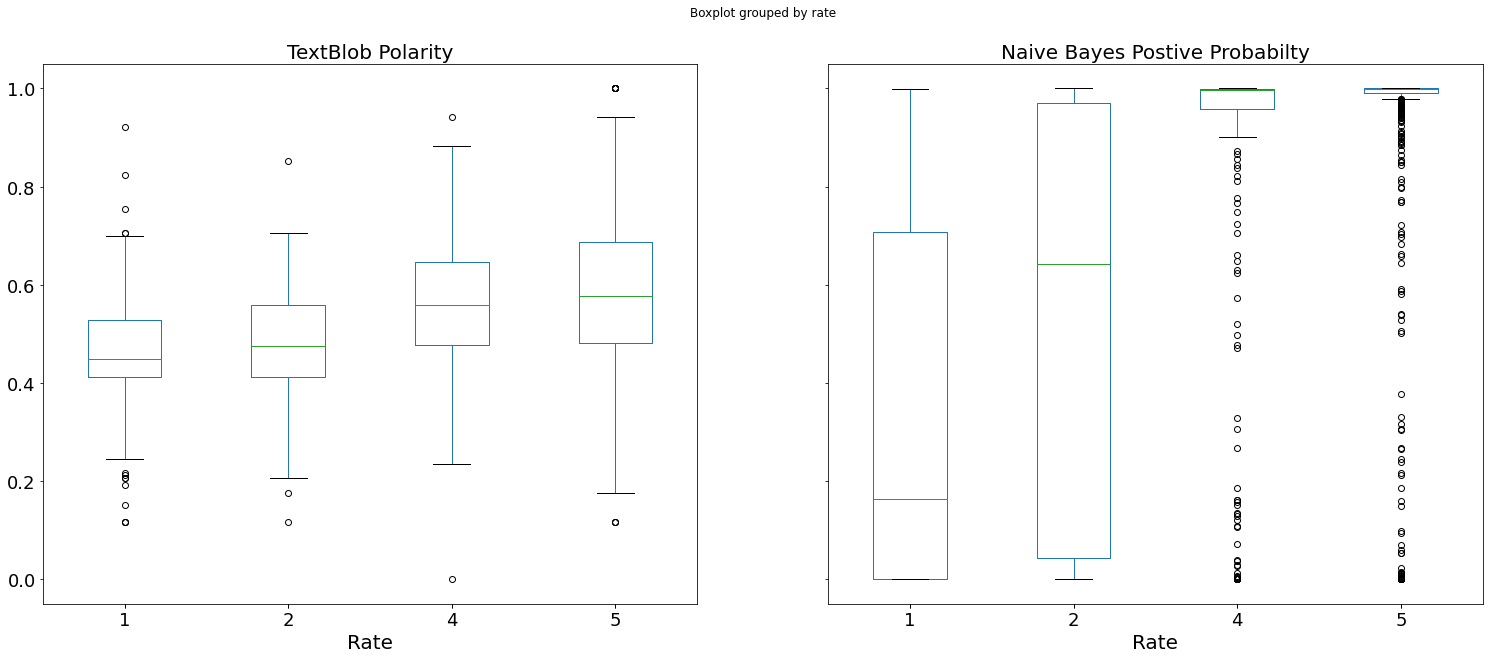

In [27]:
fig = test.boxplot(by='rate', figsize=(25,10),fontsize=18, grid=False, return_type='axes')

fig['polarity'].set_title('TextBlob Polarity', fontsize= 20)
fig['polarity'].set_xlabel('Rate', fontsize=20)
fig['prob'].set_title('Naive Bayes Postive Probabilty', fontsize= 20)
fig['prob'].set_xlabel('Rate', fontsize=20)

# plt.savefig('comparison.pdf', bbox_inchex='tight')
plt.show()

As you can see, the Naive Bayes model did a better job of discriminating between positive and negative reviews than the general polarity tool in TextBlob. Something that worths mentioning here is our model did a better job in high-rated but less performance in low-rated review texts. The reason for this is that we had less low-rated data compare to high-rated. With bringing more negative review text, these two will be more balanced.